<a href="https://colab.research.google.com/github/suhkisoo/course-v3/blob/master/Copy_of_HWlesson1_pets_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

HOMEWORK 1: Due to Sept. 21, Mon, 2020; Please provide your answers to this notebook as comments, so that the modified notebook can still be executed by the TAs and the instructor. Please submit this notebook as your homework. Note that the questions of the mid and final exams would not be so different from those of the homeworks. To submit the homeworks, please create a github repository for your homework and submit your homeworks into this repository and make your TA and teacher as contributors to the repository so that they can access it. If you have difficulty in creating your github account and repository, please consult your TA and teacher. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# Question 1: 1.1) What are "packages" in Python? - They are collections of modules. 
# 1.2) How do you import packages into your Python code? cf:  https://docs.python.org/3/tutorial/modules.html#importing-from-a-package
# - There are two ways. By using only import and by using from...import, we can import packages. 
# 1.3) In the above two statements, what does "import *" do? - It takes all modules in package.
# 1.4) In python, every thing is called an "object" including integers, 
#real numbers, functions, classes, and instances of classes, 
# though instances of classes are special citizens of this society of objects
# and thereby often called "objects".
# Please guess what category of objects does "error_rate" belong to? - function 

In [3]:
type(error_rate)

function

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 64
# Question 2: 2.1) What is the batch size? - It is the number of training examples present in a single batch.
# Note that it is used in function  ImageDataBunch.from_name_re(). 
# 2.2) What would happen when you reduce it to 16 as in the following comment? 
# - Program will use 16 training examples in a single batch. This means quadruple iteration.
# bs = 16  



## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = untar_data(URLs.PETS); path
# Question 3. 3.1) What is the value of variable URLs.PETS? - link, https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet
# 3.2) From which package would URLs.PETS have been imported? - It is imported from fastai.datasets

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [8]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [9]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [10]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [11]:
fnames = get_image_files(path_img)
fnames[:5]
# Question 4. 4.1) path_image is the path to a folder. What would be fnames? - list of filenames in path_img
# 4.2) fnames[:5] indicates that five elements from index 0 to 4 are selected from
# fnames, whose data type is called a list. What is the length of this list? - fnames[:5] is 5, fnames is 7390
# You can write and execute some Python statement involving fnames to know the length. 
# 4.3) The following is the result of executing fnames[:5]. It shows 5 image filenames.
# The filenames refer to particular images but they also contain categories or labels
# for those images. Not that our example notebook classifies a given dog or cat image into one of
# 37 categories.  Please explain how could you extract the category from a given image filename.
# You can explain by using examples. 
# - Delete unnecessary numbers and roots from the filename and leave only the category.

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_70.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_73.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_14.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_16.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_181.jpg')]

In [12]:
len(fnames)

7390

In [13]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [14]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                  size=224, bs=bs
                                  ).normalize(imagenet_stats)
# Question 5. Let us decomppose the above statement as follows:
# (a) interMediateData = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                                    size=224, bs=bs)
# (b) data = interMediateData.normalize(imagenet_stats).                                 )
# 5.1) What does (a) do? - Create ImageDataBunch from list of fnames in path with re expression pat. 
# - And Its size will be fit in 224 and 64 files will be in one batch.
# 5.2) What does (b) do? - It rescales images. 
# - It's because if each image has different scale, it will be hard to compare images.           
                                

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [15]:
data
# Question 6. The following is the result of executing "data". 
# It shows Train dataset and Validation dataset. The train dataset 
# or the validaton dataset consits of LabelList and CategoryList. 
# It also shows 5 examples from ImageList and CategoryList as an illustration.
# 6.1) How many items does LabelList of the Train dataset? - 5912
# 6.2) How many items does CategoryList of the Train dataset? - 5912
# 6.3) How many items does LabelList of the Validation dataset? - 1478
# 6.4) How many items does CategoryList of the Validation dataset? -1478
# (6.5) What do you obtain when you add the length of LabelList of the Train dataset
# and the length of LabelList of the Validation dataset?
# - When we add the length of LabeList of the Train dataset, It's learning will be more accurate, but it will be hard to test accuracy. 
# - When we add the length of LabeList of the Validation dataset, It's learning will be less accurate, but it will be easy to test accuracy. 
# 6.6) Is it the same as the length of fnames you obtained above? - train dataset + validation dataset = len(fnames)
# 6.7) What is the percentage of the length of LabelList of the Validation dataset 
#      with respect to the length of fnames? - 20% 
# 6.8) What does this percentage mean? The answer to this question should include
# the answer to the question "What the train dataset and the validation dataset
# are and how they are used in machine learning. 
# It is default percentage. When we use machine learning, we use train dataset to train program and use validation dataset to test it. 

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,great_pyrenees,english_cocker_spaniel,Ragdoll,leonberger
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,english_cocker_spaniel,leonberger,leonberger,samoyed
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

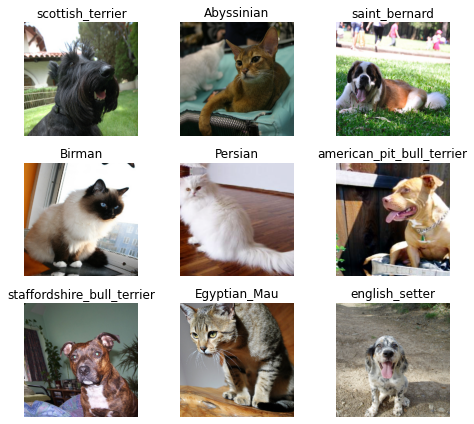

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Question 7: Function cnn_learner() combines the machine learning model "resnet34" 
# with data which includes the train dataset and the validation dataset as we examined above.
# The obtained object "learn" refers to the neural network to be trained using "data".
# But models.resent34 is a pretained neural network, that is, the neural network that is 
# already trained by using one and half a million images and thousands of categories. 
# In this notebook, we are going to train a new neural network "learn" by using less than
# 10000 dog and cat images and 37 categories. That is, we are going to retrain the
# pretrained neural network "resnet34" by using few dogs and cats images (less than 1 % of the 
# dataset used to train the original pretrained neural network). 

# 7.1) Please see the structure of the resnet34 model in this site (find out "34 layers residual"): 
# https://blog.roboflow.com/how-to-train-a-custom-resnet34-model/. 
# The neural network "learn" freezes the much of the neural network "reset34" and retain
# only a tiny part of it using the new dataset "data". [ This process is called "learning transfer".
# Because it would be so hard to obtain enough and good data to train neural networs from
# scatch, in this course we use only learning transfer. (The training neural networs from scratch
# will be covered by the next machine learning course called "Machine Learning Programming") ]
# What is the basic difference between the layers from 1 to 31 and the last layer? It will 
# help you if you try to find out wWhat "conv"  and "fc" are abbreviations of.
# - There are different how much program have learned, but the shape of the data is different. ((,,) and (,))

# 7.2) Please guess which layers would correspond to the tiny part of resnet34 to be re-trained? - maybe layer 34
# 7.3) Please guess why that kind of strategy of learning transfer would work? - This is because resnet is composed of layers.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
learn.fit_one_cycle(4)
# Question 8: (8.1) What does this statement do? - train and test program 4 times.
# (8.2) 4 refers to the number of "epochs"? What does the number of epochs 4 mean? - Yes, it refers to the number of epochs. And it means program is trained with 5912 datasets and tested with 1478 datasets repeated 4 times.
# (8.3) The following is the result of learn.fit_one_cycle(4). For each epoch, it 
# shows the train_loss and the validation_loss. Explain what they represent about 
# quality of the trained network? - train_loss is the error evaluated during training a model and valid_loss is the error during validation.
# (8.4) Guess how "error_rate" would be computed and what it represent? - It would be computed by (1 - accuracy). And it means error rate in teating.
# epoch train_loss valid_loss  error_rate time 
# 0     1.347051    0.327787   0.108931  01:39 
# 1     0.602934    0.269001   0.092016  01:39
# 2     0.385372    0.237554   0.069689  01:40
# 3     0.275950    0.231737   0.072395  01:39

epoch,train_loss,valid_loss,error_rate,time
0,1.386555,0.351326,0.116373,01:53
1,0.643416,0.278091,0.093369,01:52
2,0.383256,0.230748,0.075778,01:51
3,0.268457,0.223000,0.077131,01:52


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [21]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
# QUestion 9. 
# The following shows the lengths of the validation dataset data.valid_ds, losses, indx.
# 9.1) Are the three lengths the same? - all three lentghts are 1478
# Does this fact tell something about what losses and idxs are about?
# If so, explain this. - Losses are losses of validation datasets and indx is Indxes of validation datasets.
# 9.2) What would index idxs[0] refer to? - Index of data with the largest losses
# What would index idxs[1477] refer to? -  Index of data with the smallest losses

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [37]:
data.valid_ds

LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,english_cocker_spaniel,leonberger,leonberger,samoyed
Path: /root/.fastai/data/oxford-iiit-pet/images

In [38]:
len(losses)

1478

In [50]:
losses

tensor([8.6271e+00, 7.6382e+00, 6.7624e+00,  ..., 1.1921e-07, -0.0000e+00,
        -0.0000e+00])

In [51]:
idxs

tensor([1023, 1307,  488,  ...,  536,  551, 1038])

In [48]:
len(idxs)

1478

In [41]:
print("The length of the validation dataset [list]= ", len(data.valid_ds))

print("The length of the losses [list]= ", len(losses))

print("The length of the indices to the validation dataset [list]= ", len(idxs))


The length of the validation dataset [list]=  1478
The length of the losses [list]=  1478
The length of the indices to the validation dataset [list]=  1478


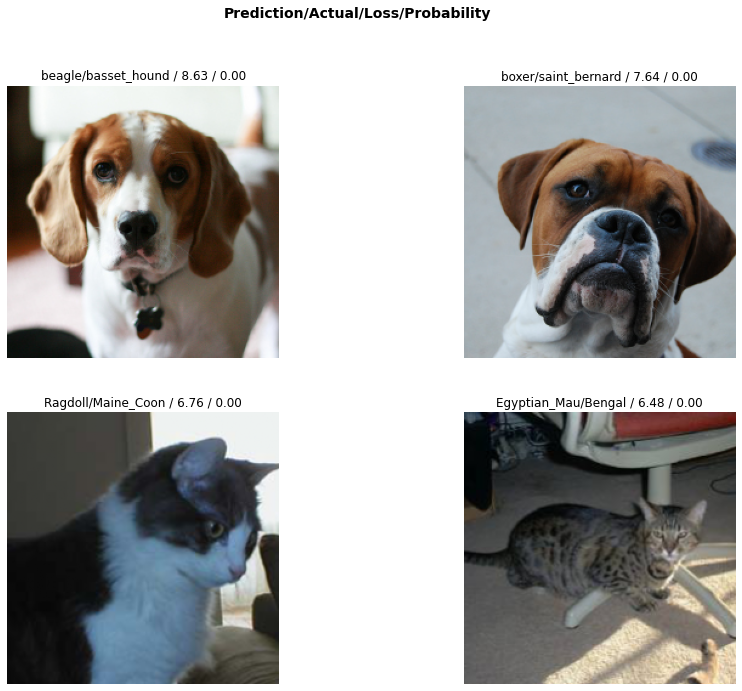

In [42]:
interp.plot_top_losses(4, figsize=(15,11))
# Question 10. The above statement displays the images in the validation dataset
# whose losses are great, more precisely whose losses belong to top 4. 
# 10.1) What does "boxer/saint_bernard/8.98/0.00" above the first picture below mean? - category prediction/actual category/loss/probability
# You can examine what the statement does by typing "interp.plot_top_losses??"
# in the cell and execute it. The doc says: the last value "0.00" refers to
# "the predicted probability assigned to the true class of the item (the first picture).”  
# In this case, the true class of the item is "saint_bernard".
# (10.2)  What does it mean that the predicted probability of this item is 0.00? 
# Does it tell something how the neural net predicts that the picture is "boxer"
# when in fact it is "saint_bernard"? - It means nerual net think that it is not an actual one. 


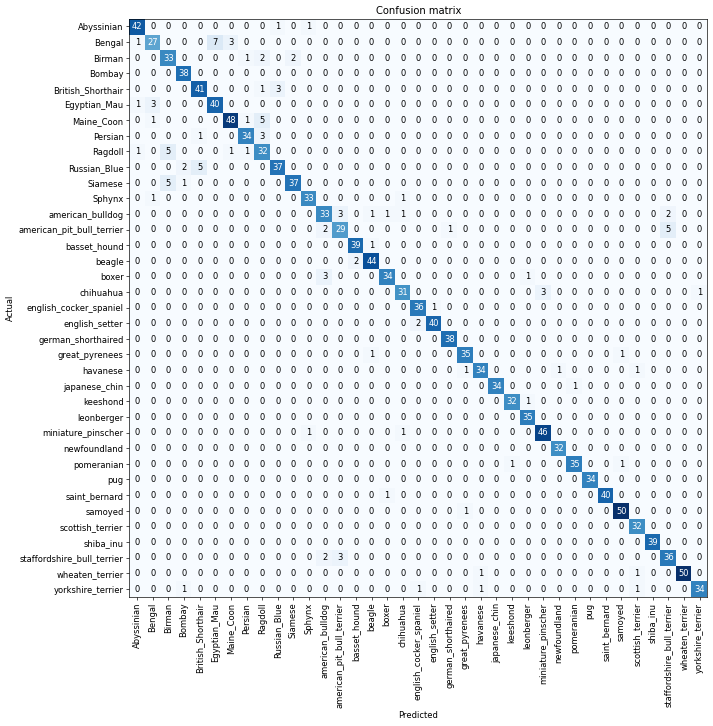

In [43]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# Question 11: 11.1) The follwing 37 x 37 matrix is the result of executing the above statement
# If you add up all the numbers in the cells of the matrix, what would it be? - 1478, the number of validation datasets 
# I recommend you just guess this number without counting the numbers in each cell.
# 11.2) What do the numbers in the diagonal of the matrix represent? - It means the number of times the prediction was correct.


In [44]:
interp.most_confused(min_val=2)
# Question 12: The following is the result of executing the above statement.
# 12.1) In  ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
#  what does number 12 refer to? - This is the number of cases where 'american_pit_bull_terrier' is incorrectly predicted as 'staffordshire_bull_terrier'.

[('Bengal', 'Egyptian_Mau', 7),
 ('Maine_Coon', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Siamese', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Bengal', 'Maine_Coon', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Persian', 'Ragdoll', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Birman', 'Ragdoll', 2),
 ('Birman', 'Siamese', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('beagle', 'basset_hound', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,error_rate,time
0,0.669956,0.380791,0.119756,01:23


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [29]:
learn.load('stage-1');

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


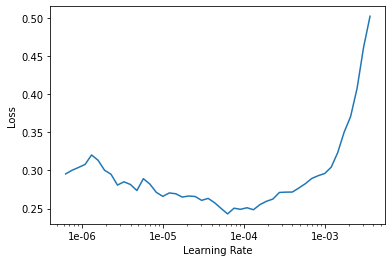

In [31]:
learn.recorder.plot()
# 

In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.245594,0.222900,0.076455,01:24
1,0.220531,0.217810,0.073072,01:24


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [33]:
learn.fit_one_cycle??


In [34]:
learn.lr_range??


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [35]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [36]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


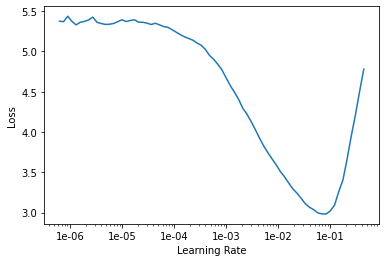

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.735563,0.318136,0.098782,02:00
1,0.480647,0.362877,0.108254,02:01
2,0.443524,0.308631,0.096752,02:02
3,0.345869,0.247082,0.074425,02:01
4,0.245364,0.218760,0.061570,02:02
5,0.190113,0.197365,0.059540,02:02
6,0.127083,0.175480,0.046685,02:02
7,0.120298,0.177183,0.050068,02:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [39]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [40]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.124612,0.174249,0.043978,02:06
1,0.093337,0.175727,0.044655,02:07
2,0.081837,0.168150,0.044655,02:08


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

If it doesn't, you can always go back to your previous model.

In [41]:
learn.load('stage-1-50');

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [43]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Ragdoll', 'Birman', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Persian', 4),
 ('Birman', 'Ragdoll', 3),
 ('Russian_Blue', 'Abyssinian', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('Maine_Coon', 'Bengal', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'saint_bernard', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('boxer', 'american_bulldog', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Other data formats

In [44]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [45]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

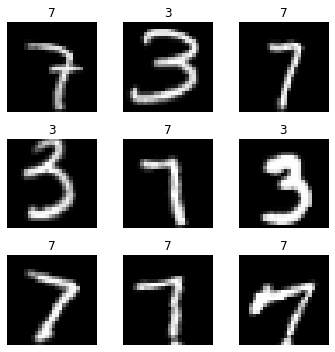

In [46]:
data.show_batch(rows=3, figsize=(5,5))

In [47]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.203888,0.113942,0.961727,00:17
1,0.120923,0.063478,0.977920,00:16


In [48]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [49]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

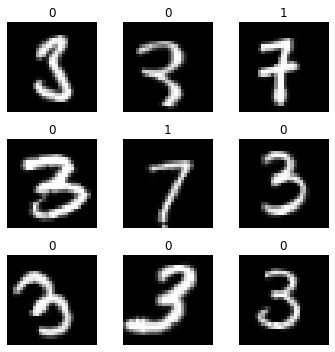

In [50]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [51]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [52]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [53]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [54]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [55]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [56]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']